In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools 
import math
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

use_cuda=torch.cuda.is_available()
device=torch.device("cuda" if use_cuda else "cpu")
print(device)

corpus="/content/drive/MyDrive/chatbot/data"
print(os.path.join(corpus,"movie_lines.txt"))

Mounted at /content/drive
cuda
/content/drive/MyDrive/chatbot/data/movie_lines.txt


In [ ]:
def timming(since):
    now=time.time()
    s=now-since
    m=int(s/60)
    s=s-m*60
    return "%dm %ds"%(m,s)
    
def printLines(file,n=10):
  with open(file,"rb") as datafile:
    lines=datafile.readlines()
    for line in lines[:n]:
      print(line)

printLines(os.path.join(corpus,"movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [ ]:
#function that creates a dictionary out of each line from above. The keys of the dictionary are in order:
#ID (like 'L1045), utteranceID(like u0), movieID(like m0), character name(like Bianca) and text (like "They do not!")
def loadLines(fileName, fields):
  lines={}
  with open(fileName,"r",encoding='iso-8859-1') as f:
    for line in f:
      values=line.split(" +++$+++ ")
      line_obj={}
      for i, field in enumerate(fields):
        line_obj[field]=values[i]
      lines[line_obj['lineID']]=line_obj
  return lines

#group the lines from loadLines into conversations according to the file movie_conversations.txt
def loadConversations(fileName,lines,fields):
  conversations=[]
  with open(fileName,"r",encoding="iso-8859-1") as f:
    for line in f:
      values=line.split(" +++$+++ ")
      conv_obj={}
      for i, field in enumerate(fields):
        conv_obj[field]=values[i]

      utterance_id_pattern=re.compile("L[0-9]+")
      line_ids=utterance_id_pattern.findall(conv_obj["utteranceIDs"])     #utteranceID

      conv_obj["lines"]=[]
      for line_id in line_ids:
        conv_obj["lines"].append(lines[line_id])

      conversations.append(conv_obj)
  
  return conversations

#extract pairs of sentences: input is line i and target is line i+1 in the conversations form the movies.
def extractSentencePairs(conversations):
  qa_pairs=[]
  for conversation in conversations:
    for i in range(len(conversation["lines"])-1):
      input_line=conversation["lines"][i]["text"].strip()
      target_line=conversation["lines"][i+1]["text"].strip()
      if input_line and target_line:
        qa_pairs.append([input_line,target_line])

  return qa_pairs

datafile=os.path.join(corpus,"formatted_movie_lines.txt")
delimiter="\t"
print(datafile)
delimiter=str(codecs.decode(delimiter,"unicode_escape"))
lines={}
conversations=[]
movie_lines_fields=["lineID", "characterID", "movieID", "character", "text"]
movie_conversations_fields=["character1ID", "character2ID", "movieID", "utteranceIDs"]
print("\nProcessing corpus...")
lines=loadLines(os.path.join(corpus,"movie_lines.txt"),movie_lines_fields)
print("\nLoading conversations...")
conversations=loadConversations(os.path.join(corpus,"movie_conversations.txt"),lines,movie_conversations_fields)
print("\nCreating sentence pairs...")
pairs=extractSentencePairs(conversations)
print("\nWriting newly formatted file...")
with open(datafile,"w",encoding="utf-8") as outputfile:
  writer=csv.writer(outputfile,delimiter=delimiter,lineterminator="\n")
  for pair in pairs:
    writer.writerow(pair)

print("\nSample of lines from file:")
printLines(datafile)

/content/drive/MyDrive/chatbot/data/formatted_movie_lines.txt

Processing corpus...

Loading conversations...

Creating sentence pairs...

Writing newly formatted file...

Sample of lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, C

In [ ]:
PAD_token=0
SOS_token=1
EOS_token=2

class Voc:
  def __init__(self,name):
    self.name=name
    self.trimmed=True
    self.word2index={}
    self.word2count={}
    self.index2word={PAD_token:"PAD",SOS_token:"SOS",EOS_token:"EOS"}
    self.num_words=3

  def addSentence(self,sentence):
    for word in sentence.split(" "):
      self.addWord(word)

  def addWord(self,word):
    if word not in self.word2index:
      self.word2index[word]=self.num_words
      self.index2word[self.num_words]=word
      self.word2count[word]=1
      self.num_words+=1
    else:
      self.word2count[word]+=1

  # Remove words below a certain count threshold
  def trim(self, min_count):
    if self.trimmed:
      return
    self.trimmed = True

    keep_words = []

    for k, v in self.word2count.items():
      if v >= min_count:
        keep_words.append(k)

    print("keep_words %d / %d = %.4f"%(len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)))

        # Reinitialize dictionaries
    self.word2index = {}
    self.word2count = {}
    self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
    self.num_words = 3 # Count default tokens

    for word in keep_words:
      self.addWord(word)


#Clean up strings
max_length=10

def unicodeToAscii(s):
  return "".join([c for c in unicodedata.normalize("NFD",s) if unicodedata.category(c)!="Mn"])

def normalizeString(s):
  s=unicodeToAscii(s.lower().strip())
  s=re.sub(r"([.!?])",r" \1",s)
  s=re.sub(r"[^a-zA-Z.!?]+",r" ",s)
  s=re.sub(r"\s+",r" ",s).strip()
  return s

#normalizeString("Andrei is done!?*")
def readVocs(datafile,corpus_name):
  print("Reading lines...")
  lines=open(datafile,encoding="utf-8").read().strip().split("\n")
  pairs=[[normalizeString(s) for s in l.split("\t")] for l in lines]
  voc=Voc(corpus_name)
  return voc, pairs

def filterPair(pair):
  return len(pair[0].split(" "))<max_length and len(pair[1].split(" "))<max_length

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

def loadPrepareData(corpus, corpus_name, datafile, save_dir):
  print("Start preparing data...")
  voc, pairs = readVocs(datafile,corpus_name)
  print("Read %d sentence pairs"%(len(pairs)))
  pairs=filterPairs(pairs)
  print("Trimmed to %d sentence pairs"%(len(pairs)))
  print("Started counting words...")
  for pair in pairs:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
  print("Added %d words"%(voc.num_words))
  return voc, pairs

save_dir="/content/drive/MyDrive/chatbot/process_data"
corpus_name="movie_lines.txt"
voc, pairs=loadPrepareData(corpus,corpus_name,datafile,save_dir)

print("\nExample of pairs")
for pair in pairs[:10]:
  print(pair)

#remove rare words
min_count=3
def trimRareWords(voc,pairs,min_count):
  # Trim words used under the MIN_COUNT from the voc
  voc.trim(min_count)
  # Filter out pairs with trimmed words
  keep_pairs = []
  for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    # Check input sentence
    for word in input_sentence.split(' '):
      if word not in voc.word2index:
        keep_input = False
        break
        # Check output sentence
    for word in output_sentence.split(' '):
      if word not in voc.word2index:
        keep_output = False
        break
    # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
    if keep_input and keep_output:
      keep_pairs.append(pair)
  print("Trimmed from %d to %d pairs, %.2f%% of the total"%(len(pairs),len(keep_pairs),100*len(keep_pairs)/len(pairs)))

  return keep_pairs

pairs=trimRareWords(voc,pairs,min_count)  

Start preparing data...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Started counting words...
Added 18008 words

Example of pairs
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']
Trimmed from 64271 to 64271 pairs, 100.00% of the total


In [ ]:
#prepare data for AI
def indexesFromSentence(voc, sentence):
  res=[voc.word2index[word] for word in sentence.split(" ")]
  res.append(EOS_token)
  return res

def zeroPadding(l,fillvalue=PAD_token):
  return list(itertools.zip_longest(*l,fillvalue=fillvalue))

def binaryMatrix(l,value=PAD_token):
  m=[]
  for i,seq in enumerate(l):
    m.append([])
    for token in seq:
      if token==PAD_token:
        m[i].append(0)
      else:
        m[i].append(1)
  return m

def inputVar(l,voc):
  indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
  lengths=torch.tensor([len(indexes) for indexes in indexes_batch])
  padList=zeroPadding(indexes_batch)
  padVar=torch.LongTensor(padList)
  return padVar, lengths

def outputVar(l,voc):
  indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
  max_target_len=max([len(indexes) for indexes in indexes_batch])
  padList=zeroPadding(indexes_batch)
  padVar=torch.LongTensor(padList)
  mask=binaryMatrix(padList)
  mask=torch.BoolTensor(mask)
  return padVar, mask, max_target_len

def batch2TrainData(voc,pair_batch):
  pair_batch.sort(key=lambda x:len(x[0].split(" ")),reverse=True)
  input_batch, output_batch =[], []
  for pair in pair_batch:
    input_batch.append(pair[0])
    output_batch.append(pair[1])
  
  inp, lengths = inputVar(input_batch,voc)
  out, mask, max_target_len = outputVar(output_batch,voc)
  return inp, lengths, out, mask, max_target_len

small_batch_size=5
batches=batch2TrainData(voc,[random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len=batches

print("Input variable:")
print(input_variable) 
print("Length of input:")
print(lengths)
print("Target variable:")
print(target_variable)
print("Mask:")
print(mask)
print("Maximum target length:")
print(max_target_len)

Input variable:
tensor([[ 304,   79,   64,   52, 8124],
        [  55,   39,   39,    6,    2],
        [4265,  117,   55,    2,    0],
        [  11,   11, 6117,    0,    0],
        [  28,   26,   42,    0,    0],
        [  43,  312,  512,    0,    0],
        [ 203,    4,    4,    0,    0],
        [2350,    2,    2,    0,    0],
        [   4,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
Length of input:
tensor([10,  8,  8,  3,  2])
Target variable:
tensor([[ 3120,    52,   316,   467,  1928],
        [ 9336,     6,    64,     7,   978],
        [    4,     2,    39,  2384,   257],
        [    2,     0,  1052,    86,     9],
        [    0,     0,    55,     6, 13208],
        [    0,     0,  2832,     2,     4],
        [    0,     0,     4,     0,     2],
        [    0,     0,     2,     0,     0]])
Mask:
tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, Fa

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self,hidden_size,embedding, n_layers=1,dropout=0):
    super().__init__()
    self.n_layers=n_layers
    self.hidden_size=hidden_size
    self.embedding=embedding

    self.gru=nn.GRU(hidden_size,2*hidden_size,n_layers,dropout=(0 if n_layers==1 else dropout),bidirectional=True)
    self.linear1=nn.Linear(2*hidden_size,hidden_size)
    self.linear2=nn.Linear(2*hidden_size,hidden_size)
    self.gru_f=nn.GRU(hidden_size,hidden_size,dropout=(0 if n_layers==1 else dropout))
    self.gru_b=nn.GRU(hidden_size,hidden_size,dropout=(0 if n_layers==1 else dropout))
    self.gru_fb=nn.GRU(hidden_size,hidden_size,dropout=(0 if n_layers==1 else dropout))
    self.gru_bb=nn.GRU(hidden_size,hidden_size,dropout=(0 if n_layers==1 else dropout))
    #self.linear_hidden2=nn.Linear(2*hidden_size,hidden_size)
    self.linear_hidden=nn.Linear(2*hidden_size,hidden_size)

  def forward(self,input_seq,input_lengths,hidden=None):
    embedded=self.embedding(input_seq)
    packed=nn.utils.rnn.pack_padded_sequence(embedded,input_lengths)
    outputs,hidden=self.gru(packed,hidden)
    outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
    #print(hidden.shape)
    seq_len=hidden.shape[0]
    batch_size=hidden.shape[1]
    new_hidden=torch.zeros((seq_len,batch_size,2*self.hidden_size)).to(device)
    for i in range(batch_size):
      _,hidden1=self.gru_f(hidden[:,i,:self.hidden_size])
      _,hidden2=self.gru_b(hidden[:,batch_size-i-1,self.hidden_size:])
      new_hidden[:,i,:]=torch.cat((hidden1,hidden2),dim=1)

    hidden=torch.zeros((seq_len,batch_size,2*self.hidden_size)).to(device)
    for i in range(seq_len):
      _,hidden1=self.gru_fb(new_hidden[i,:,:self.hidden_size])
      _,hidden2=self.gru_bb(new_hidden[seq_len-i-1,:,self.hidden_size:])
      hidden[i,:,:]=torch.cat((hidden1,hidden2),dim=1)

    outputs1=self.linear1(outputs[:,:,:2*self.hidden_size])
    outputs2=self.linear2(outputs[:,:,2*self.hidden_size:])
    outputs=outputs1+outputs2
    hidden=self.linear_hidden(hidden)
    return outputs, hidden

# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


class LuongAttnDecoderRNN(nn.Module):
  def __init__(self,attn_model,embedding,hidden_size,output_size,n_layers=1,dropout=0.1):
    super().__init__()

    self.attn_model=attn_model
    self.embedding=embedding
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.n_layers=n_layers
    self.dropout=dropout

    self.embedding_dropout=nn.Dropout(dropout)

    self.gru=nn.GRU(hidden_size,hidden_size,n_layers,dropout=(0 if n_layers==1 else dropout))

    self.concat=nn.Linear(2*hidden_size,hidden_size)

    self.out=nn.Linear(hidden_size,output_size)

    self.attn=Attn(attn_model,hidden_size) 

  def forward(self,input_step,last_hidden,encoder_outputs):
    #obtain embedding
    embedded=self.embedding(input_step)
    embedded=self.embedding_dropout(embedded)

    #feed into the GRU with the last hidden states
    rnn_output, hidden=self.gru(embedded,last_hidden)       #hidden_size on dim 1

    #obtain attention weights using the previous class
    attn_weights=self.attn(rnn_output,encoder_outputs)      #hidden_size on dim 1

    #multiply the attention weights with the encoder output
    context=attn_weights.bmm(encoder_outputs.transpose(0,1))    #dot product with result of hidden_size on dim 1

    #Luong equation 5
    rnn_output=rnn_output.squeeze(0)
    context=context.squeeze(1) 
    concat_input=torch.cat((rnn_output,context),1)          #2*hidden_size on dim 1
    concat_output=torch.tanh(self.concat(concat_input))

    output=self.out(concat_output)
    output=F.softmax(output,dim=1)

    return output, hidden


def maskNLLLoss(inp,target,mask):
  nTotal=mask.sum()
  crossEntropy=-torch.log(torch.gather(inp,1,target.view(-1,1)).squeeze(1))
  loss=crossEntropy.masked_select(mask).mean()
  loss=loss.to(device)
  return loss, nTotal.item()

In [ ]:
clip=50
teacher_forcing_ratio=1
learning_rate=10**(-4)
decoder_learning_ratio=5
n_iterations=10**(5)
print_every=10**(2)
save_every=500

attn_model="dot"
hidden_size=500
encoder_n_layers=2
decoder_n_layers=2
dropout=0.1
batch_size=64

embedding=nn.Embedding(voc.num_words,hidden_size)
encoder=EncoderRNN(hidden_size,embedding,encoder_n_layers,dropout).to(device)
decoder=LuongAttnDecoderRNN(attn_model,embedding,hidden_size,voc.num_words,decoder_n_layers,dropout).to(device)

criterion=nn.CrossEntropyLoss(ignore_index=PAD_token)

encoder.train()
decoder.train()

encoder_optimizer=torch.optim.Adam(encoder.parameters(),learning_rate)
decoder_optimizer=torch.optim.Adam(decoder.parameters(),learning_rate*decoder_learning_ratio)

n_pairs=len(pairs)
training_batches=[batch2TrainData(voc,[pairs[i] for i in np.random.choice(list(range(n_pairs)),size=batch_size)]) for _ in range(n_iterations)]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
all_train_losses=[]
start=time.time()

for iteration in range(1,n_iterations+1):
  
  training_batch=training_batches[iteration-1]

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_variable, lengths, target_variable, mask, max_target_len=training_batch

  input_variable=input_variable.to(device)
  lengths=lengths.to("cpu")
  target_variable=target_variable.to(device)
  mask=mask.to(device)

  loss=0
  n_totals=0

  encoder_outputs, encoder_hidden=encoder(input_variable,lengths)
  decoder_input=torch.LongTensor([[SOS_token for _ in range(batch_size)]]).to(device)

  encoder_outputs=encoder_outputs.to(device)
  decoder_hidden=encoder_hidden[:decoder.n_layers]

  use_teacher_forcing=True if random.random()<teacher_forcing_ratio else False

  if use_teacher_forcing:
    for t in range(max_target_len):
      decoder_output, decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
      decoder_input=target_variable[t].view(1,-1)

      mask_loss, nTotal=maskNLLLoss(decoder_output,target_variable[t],mask[t])
      last_loss=mask_loss.item()*nTotal
      loss+=mask_loss*nTotal
      all_train_losses.append(last_loss)
      n_totals+=nTotal 
  else:
    for t in range(max_target_len):
      decoder_output, decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
      _,topi=decoder_output.topk(1)
      decoder_input=torch.LongTensor([[topi[i][0] for i in range(batch_size)]])

      mask_loss, nTotal=maskNLLLoss(decoder_output,target_variable[t],mask[t])
      last_loss=mask_loss.item()*nTotal
      loss+=mask_loss*nTotal
      all_train_losses.append(last_loss)
      n_totals+=nTotal

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  if iteration%print_every==0:
    print("Completion:%.2f%% \t Time:%s \t Avg loss:%.4f \t Last loss:%.7f"%(100*iteration/n_iterations,timming(start),np.mean(all_train_losses),last_loss))
    
    

RuntimeError: ignored

In [ ]:
save_model_path="/content/drive/MyDrive/chatbot/save_models"
save_encoder_file="/TwoDoubleDirection_chatbot_encoder,encoder=%d,loss=%.4f.pt"%(encoder_n_layers,np.mean(all_train_losses))
save_decoder_file="/TwoDoubleDirection_chatbot_decoder,decoder=%d,loss=%.4f.pt"%(decoder_n_layers,np.mean(all_train_losses))

torch.save(encoder,save_model_path+save_encoder_file)
torch.save(decoder,save_model_path+save_decoder_file)

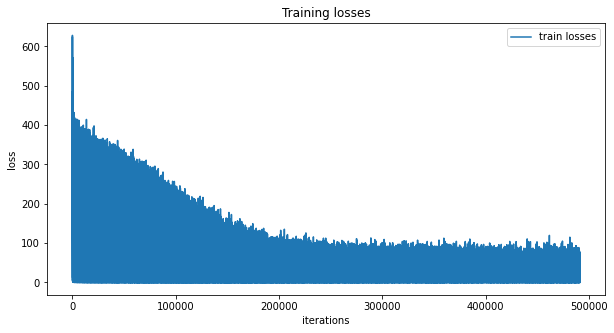

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training losses")
plt.plot(all_train_losses,label="train losses")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

def evaluate(encoder, decoder, searcher, voc, sentence, max_length=max_length):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [ ]:
encoder.eval()
decoder.eval()
searcher=GreedySearchDecoder(encoder,decoder)
evaluateInput(encoder,decoder,searcher,voc)

> hi
Bot: hi . . . how are you ?
> how are you?
Bot: head still secure to the neck . .
> do you have a brain?
Bot: no . . much . .


KeyboardInterrupt: ignored